# CNN


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Convolutional Neural Network - Classifiying CIFAR-10

### Data Preprocessing

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Image shape:  torch.Size([3, 32, 32])
       cat       bird       frog      plane


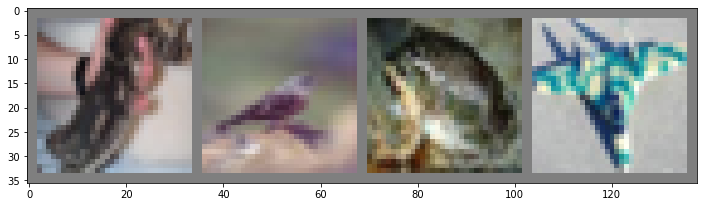

In [3]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # plt accepts images in the format (w,h,c)
    
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter) #Changed

print("Image shape: ", images[0].shape)
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%10s' % classes[labels[j]] for j in range(4)))

### Construct a CNN in PyTorch

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10) 
        self.relu = nn.ReLU()
        pass
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
criterion = None
optimizer = None
learning_rate=1e-3
momentum=0.9
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print("using {} device".format(device))

trainset_size=len(trainloader.dataset)

def training_loop(trainloader,optimizer,criterion,net,num_epoch=100):
    for epoch in range(num_epoch):  # loop over the dataset multiple times
        running_loss = 0.0
        samples_num=0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            samples_num+=inputs.shape[0]
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0
        running_loss=np.round(running_loss/samples_num,4)
        print("training loss {} epoch {}".format(running_loss,epoch))
    print('Finished Training')

training_loop(trainloader,optimizer,criterion,net,20)

using cpu device
training loss 0.0359 epoch 0
training loss 0.0333 epoch 1
training loss 0.0298 epoch 2
training loss 0.0274 epoch 3
training loss 0.0257 epoch 4
training loss 0.0243 epoch 5
training loss 0.0233 epoch 6
training loss 0.0225 epoch 7
training loss 0.0218 epoch 8
training loss 0.0211 epoch 9
training loss 0.0206 epoch 10
training loss 0.02 epoch 11
training loss 0.0196 epoch 12
training loss 0.0191 epoch 13
training loss 0.0187 epoch 14
training loss 0.0183 epoch 15
training loss 0.0179 epoch 16
training loss 0.0176 epoch 17
training loss 0.0172 epoch 18
training loss 0.0169 epoch 19
Finished Training


## Model evaluation

Calculate the model accuracy and print a confusion matrix where in y axis represents the real category and the x axis represents the predicted category

In [7]:
confusion_matrix = np.zeros([10,10], int)
model_accuracy = 0
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
correct = 0
total = 0

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            confusion_matrix[label,prediction]+=1
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
        total += labels.size(0)
        correct += (predictions == labels).sum().item()
    model_accuracy = 100 * correct // total

        
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
print('Model accuracy on {0} test images: {1:.2f}%'.format(len(testset), model_accuracy))

Accuracy for class: plane is 59.5 %
Accuracy for class: car   is 73.3 %
Accuracy for class: bird  is 51.6 %
Accuracy for class: cat   is 37.6 %
Accuracy for class: deer  is 51.0 %
Accuracy for class: dog   is 52.6 %
Accuracy for class: frog  is 61.4 %
Accuracy for class: horse is 74.0 %
Accuracy for class: ship  is 73.8 %
Accuracy for class: truck is 62.8 %
Model accuracy on 10000 test images: 59.00%


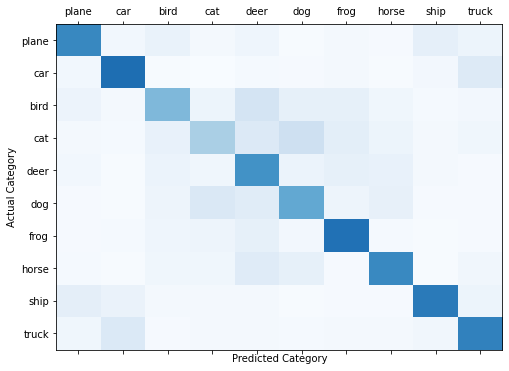

In [122]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()

# Localization as Regression

ResNet18 that was trained on ImageNet.
ImageNet has 1,000 classes and 1,000,000 images. In this part, we will use the features extracted from ResNet18 to localize and classify images of cats and dogs. 

Using a pretrained network as a building block for a more complicated task is at the heart of neural networks today. By leveraging the features ResNet18 extracts, we can train a model that can correctly classify and localize cats and dogs using very few images. 

In [8]:
import torchvision.transforms as transforms
from data.dataloader import *
from torchvision.models import resnet18, ResNet18_Weights
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.models as models
import torch.nn as nn
from PIL import Image
import collections
import time
import copy
import sys
import os

In [9]:
resnet18 = resnet18(weights=ResNet18_Weights.DEFAULT)

ResNet takes as input images of size (224,224). We will use PyTorch Transforms to change the size of the images. When ResNet18 was trained on ImageNet, the images were normalized using the mean and standard deviation of the images. In order to properly use the weights, we will use the same normalization.

In [10]:
data_transforms = {
    'train': transforms.Compose([
        Rescale((224,224)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalizing according to imagenet
    ]),
    'val': transforms.Compose([
        Rescale((224,224)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
root_dir = "data/animals/"
datasets = {x: VOCDetection(root_dir, image_set=x, transform=data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=32, shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}
classes = datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(dataset_sizes)

{'train': 636, 'val': 158}


In [11]:
# Get a batch of training data
sample = next(iter(dataloaders['train']))

<Figure size 864x576 with 0 Axes>

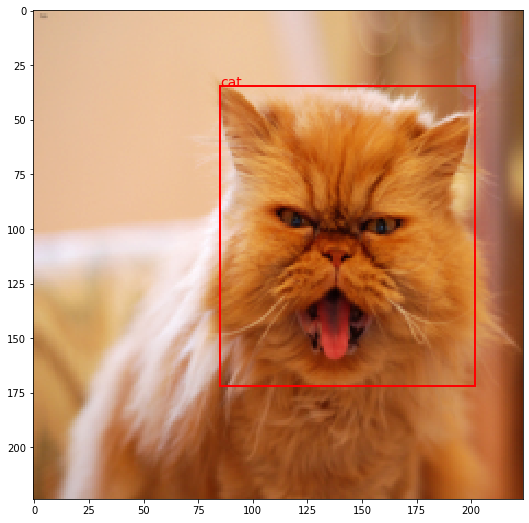

In [12]:
def imshow(img, label, bbox):
    image = np.copy(img[0])
    image = np.transpose(image, (1, 2, 0))
    image *= np.array([0.229, 0.224, 0.225])
    image += np.array([0.485, 0.456, 0.406])
    label = label[0]
    bbox = bbox[0]
    plt.figure();
    fig, ax = plt.subplots(1, figsize=(12,9));
    ax.imshow(image);
    x1, y1, x2, y2 = bbox.numpy().reshape(-1) * 224
    box_w, box_h = np.abs(x2-x1), np.abs(y2-y1)
    bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, 
                             edgecolor='r', facecolor='none');
    ax.add_patch(bbox);
    ax.annotate(classes[label], (x1, y1), color='r', fontsize=14);

imshow(sample['image'],sample['label'],sample['bbox'])

In [13]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        # Load the pretrained ResNet model
        self.resnet = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)
        for param in resnet18.parameters():
            param.requires_grad = False
        # Define the two new parallel layers
        in_features =  self.resnet.fc.in_features
        self.resnet.fc=Identity()

        self.fc = nn.Sequential(
            nn.Dropout(),
            nn.Linear(in_features, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(True),
            nn.Linear(4096, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(True)
        ).to(device)
        # Adding Labels Classification
        self.classifier = nn.Sequential(
            nn.Linear(4096, num_classes),
            nn.ReLU(True)
        )
        # Adding bounding box regression layer will yeild the obunding box prediction
        num_detections = 4
        self.detector = nn.Sequential(
            nn.Linear(4096, num_detections),
            nn.ReLU(True)
        ).to(device)


    def forward(self, images):
        #images = images.to(device)
        x = images['image']
        x = self.resnet(x)
        x = self.fc(x)
        bbox = self.detector(x)
        labels = self.classifier(x)
        return labels, bbox

In [178]:
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle    
    xA = torch.maximum(boxA[:, 0], boxB[:, 0])
    yA = torch.maximum(boxA[:, 1], boxB[:, 1])
    xB = torch.minimum(boxA[:, 2], boxB[:, 2])
    yB = torch.minimum(boxA[:, 3], boxB[:, 3])
    # compute the area of intersection rectangle
    zeros = torch.zeros(xA.shape)
    interArea = torch.maximum(zeros, xB - xA + 1) * torch.maximum(zeros, yB - yA + 1)
    #interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # compute the area of both the prediction and ground-truth
    # rectangles
    
    boxAArea = (boxA[:, 2] - boxA[:, 0] + 1) * (boxA[:, 3] - boxA[:, 1] + 1)
    boxBArea = (boxB[:, 2] - boxB[:, 0] + 1) * (boxB[:, 3] - boxB[:, 1] + 1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = torch.sum(interArea / (boxAArea + boxBArea - interArea))

    # return the intersection over union value
    return iou


def train_model(model, criterion_cls, criterion_bbox, optimizer, scheduler=None, num_epochs=5):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict()) # this is how a model is copied
    best_acc = 0.0
    history={}
    history['loss_history_train'] = []
    history['accuracy_history_train'] = []
    history['iou_history_train'] = []
    history['loss_history'] = []
    history['accuracy_history'] = []
    history['iou_history'] = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0   # total loss of the network at each epoch
            running_corrects = 0 # number of correct predictions
            iou = 0.0            # IoU score
            # Iterate over data.
            for sample in dataloaders[phase]:
                #Forward
                optimizer.zero_grad()
                outputs=model(sample)
                #Outputs
                labels=sample['label']
                bbox=sample['bbox']
                #Losses
                loss_cls = criterion_cls(outputs[0], labels)
                loss_bbox=criterion_bbox(outputs[1],bbox)
                loss = loss_cls + loss_bbox
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                #Total loss
                running_loss+=loss

                #Accuracy for classification
                _, predicted = torch.max(outputs[0].data, 1)
                iter_acc=(predicted == labels).sum().item()
                running_corrects += iter_acc
                outputs = outputs[1].squeeze(1)
                iou+=bb_intersection_over_union(outputs,bbox)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            iou = iou / dataset_sizes[phase]
            
            if phase == 'train':
                history['loss_history_train'].append(epoch_loss)
                history['accuracy_history_train'].append(epoch_acc)
                history['iou_history_train'].append(iou)
            else:
                history['loss_history'].append(epoch_loss)
                history['accuracy_history'].append(epoch_acc)
                history['iou_history'].append(iou)
            
            print('{} Loss: {:.4f}  |  Acc: {:.4f}  |  IOU: {:.4f}'.format(
                phase, epoch_loss, epoch_acc, iou))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,history


Choose your optimizer and the loss functions for the classification and bounding box regression.

In [179]:
import torch.optim as optim

cnn = CNN(2)
cnn = cnn.to(device)

criterion_cls = None
criterion_bbox = None
optimizer = None
criterion_cls = nn.CrossEntropyLoss()
criterion_bbox = nn.SmoothL1Loss()
optimizer = optim.SGD(cnn.parameters(), lr=0.003, momentum=0.9)

In [180]:
best_model,history = train_model(cnn, criterion_cls, criterion_bbox, optimizer, num_epochs=10)

Epoch 1/10
----------
train Loss: 0.0208  |  Acc: 0.6855  |  IOU: 0.4789
val Loss: 0.0163  |  Acc: 0.9810  |  IOU: 0.4130
Epoch 2/10
----------
train Loss: 0.0142  |  Acc: 0.9308  |  IOU: 0.5554
val Loss: 0.0121  |  Acc: 0.9873  |  IOU: 0.6381
Epoch 3/10
----------
train Loss: 0.0126  |  Acc: 0.9858  |  IOU: 0.5782
val Loss: 0.0117  |  Acc: 0.9937  |  IOU: 0.6603
Epoch 4/10
----------
train Loss: 0.0122  |  Acc: 0.9811  |  IOU: 0.5888
val Loss: 0.0121  |  Acc: 0.9873  |  IOU: 0.6690
Epoch 5/10
----------
train Loss: 0.0121  |  Acc: 1.0000  |  IOU: 0.5938
val Loss: 0.0118  |  Acc: 0.9937  |  IOU: 0.6692
Epoch 6/10
----------
train Loss: 0.0121  |  Acc: 0.9890  |  IOU: 0.6059
val Loss: 0.0118  |  Acc: 0.9937  |  IOU: 0.6827
Epoch 7/10
----------
train Loss: 0.0119  |  Acc: 0.9969  |  IOU: 0.6115
val Loss: 0.0121  |  Acc: 0.9937  |  IOU: 0.6715
Epoch 8/10
----------
train Loss: 0.0119  |  Acc: 0.9937  |  IOU: 0.6153
val Loss: 0.0117  |  Acc: 0.9937  |  IOU: 0.6856
Epoch 9/10
----------
tr

Once you are pleased with your results, see how your model can predict and localize cats and dogs!

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 864x576 with 0 Axes>

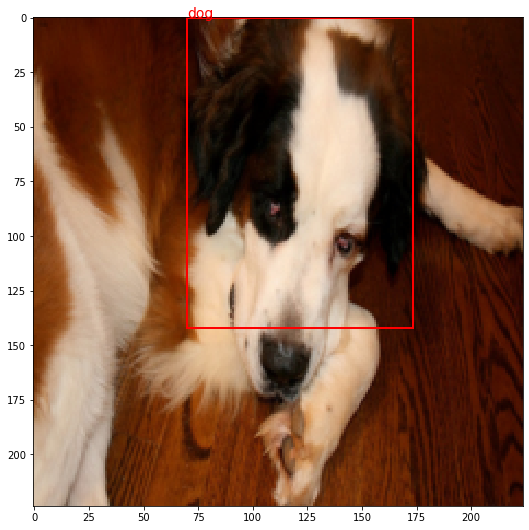

In [181]:
# Get a batch of validation data
sample = next(iter(dataloaders['val']))
with torch.no_grad():
    #images = sample['image']
    #images = images.to(device)
    label_pred, bbox_pred = best_model(sample)
    _, label_pred = torch.max(label_pred, 1)
imshow(sample['image'], label_pred.cpu(), bbox_pred.cpu())

Your visualizations here (IoU / Accuracy / Loss on training and validation datasets as a function of the epoch). Only visualize the results of your best model.

In [182]:
def tensorList2floatList(lst):
    return list(map(float, lst))

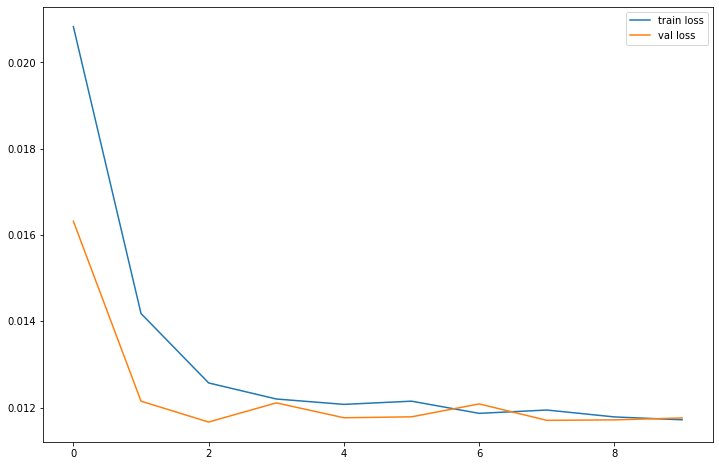

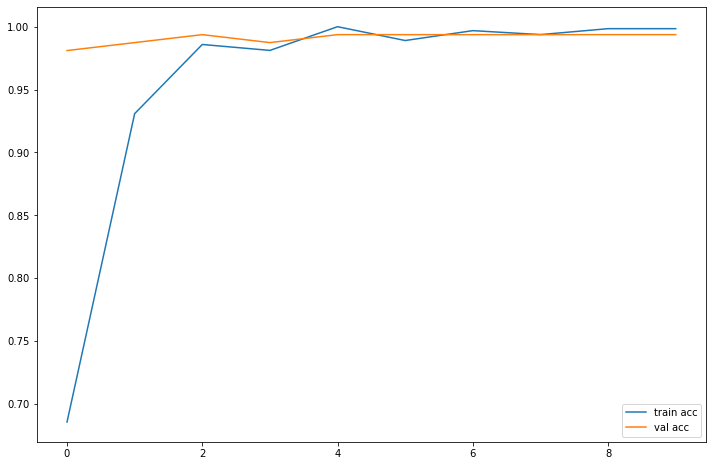

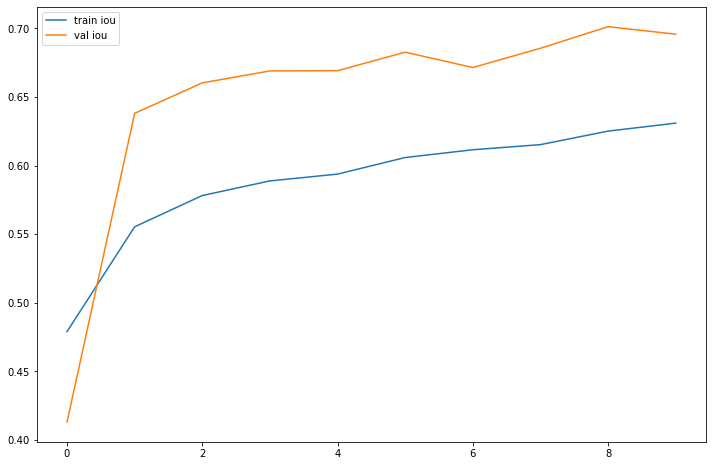

In [183]:
plt.plot(tensorList2floatList(history['loss_history_train']))
plt.plot(tensorList2floatList(history['loss_history']))
plt.legend(('train loss','val loss'))
plt.show()

plt.plot(tensorList2floatList(history['accuracy_history_train']))
plt.plot(tensorList2floatList(history['accuracy_history']))
plt.legend(('train acc','val acc'))
plt.show()

plt.plot(tensorList2floatList(history['iou_history_train']))
plt.plot(tensorList2floatList(history['iou_history']))
plt.legend(('train iou','val iou'))
plt.show()